In [ ]:
import torch

if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla T4


# 上網找一張 image file, e.g., cat, dog, ..

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cat.jpg to cat.jpg


In [ ]:
fnameLst = list(uploaded.keys())
fname = fnameLst[0]
print(fname)

cat.jpg


(1575, 2800, 3)


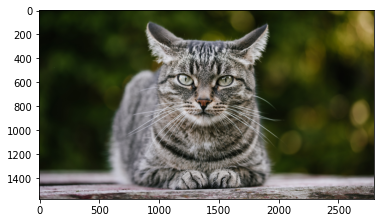

In [ ]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread(fname)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
print(image.shape)
plt.imshow(image)
plt.show()

# Build a CNN

Convolution and max. pooling animation: https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

In [ ]:
import torch.nn as nn
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()
    self.FeatureExtractionLayer = nn.Sequential(
        nn.Conv2d(3, 32, 3, 1, 1),  #feature map size=(64+2*1-3)/1 + 1 = 64
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2, 0), #feature map size=(64+2*0-2)/2 + 1 = 32
        nn.Conv2d(32, 8, 3, 1, 1), #feature map size=(32+2*1-3)/1 + 1 = 32
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2, 0),     #feature map size=(32+2*0-2)/2 + 1 = 16
    )
    self.MLPClassifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(8 * 16 * 16, 500), 
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(500, 100),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(100, 2),
    )

  def forward(self, x):
    x = self.FeatureExtractionLayer(x)
    x = torch.flatten(x, 1)
    x = self.MLPClassifier(x)
    return x

In [ ]:
MyCNN = MyCNN().to(device)
print(MyCNN)

MyCNN(
  (FeatureExtractionLayer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (MLPClassifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2048, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=100, out_features=2, bias=True)
  )
)


# Input image processing: resize, center crop, normalize and convert to tensor

In [ ]:
from torchvision import transforms
transformer = transforms.Compose([
     transforms.Resize(224),
     transforms.CenterCrop(64),            
     transforms.ToTensor(),                     
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5] )])

In [ ]:
from PIL import Image
PILImg= Image.fromarray(image.astype('uint8')).convert('RGB')
PILImg = transformer(PILImg)
PILImg.shape

torch.Size([3, 64, 64])

# Visualize the input image after preprocessing

In [ ]:
import numpy as np
# Tensor is channel first, to plot, we need to convert to channel last
PILImgArray = np.zeros((PILImg.shape[1], PILImg.shape[2], 3))
PILImgArray[:,:,0] = PILImg[0, :, :]  
PILImgArray[:,:,1] = PILImg[1, :, :]
PILImgArray[:,:,2] = PILImg[2, :, :]
print(PILImgArray.shape, PILImgArray.min(), PILImgArray.max())

(64, 64, 3) -0.9686274528503418 0.7960784435272217


In [ ]:
PILImgArray = PILImgArray*0.5+0.5  # 把 -1~1 變成 0~1
print(PILImgArray.shape, PILImgArray.min(), PILImgArray.max())

(64, 64, 3) 0.0156862735748291 0.8980392217636108


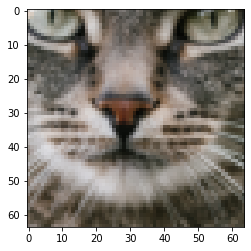

In [ ]:
plt.imshow(PILImgArray)
plt.show()

# Pass input image to first convolution layer

In [ ]:
batchX = torch.unsqueeze(PILImg, 0)
batchX = batchX.to(device)
batchX.shape

torch.Size([1, 3, 64, 64])

In [ ]:
conv1 = MyCNN.FeatureExtractionLayer[0]
print(conv1) #InChannel=3(RGB), OutChannel=32, convolution filter size=3, stride=1, padding=1

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
weight1 = conv1.weight.data.cpu().numpy()
print(weight1.shape) # 32個convolution filters, 每個filter 的 depth=3, 有3*3個參數 

(32, 3, 3, 3)


In [ ]:
conv1_out = conv1(batchX.to(device))
conv1_out.shape #輸入影像通過第一層convolution layer後產生32個feature maps

torch.Size([1, 32, 64, 64])

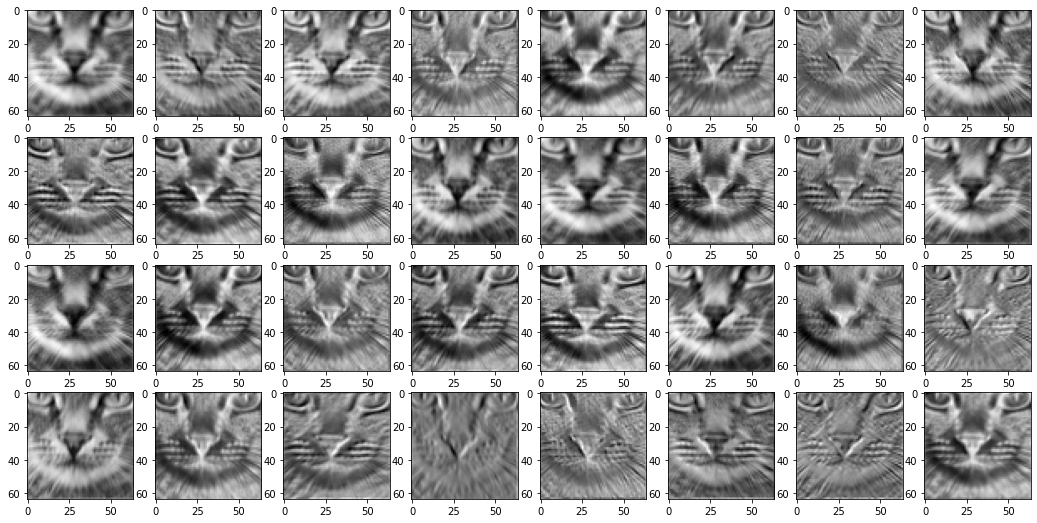

In [ ]:
# Visualize 輸入影像通過第一層convolution layer後產生32個feature maps
imgArray=conv1_out[0].data.cpu().numpy()
fig=plt.figure(figsize=(18, 9))
for i in range(32):
    fig.add_subplot(4, 8, i+1) 
    plt.imshow(imgArray[i], cmap='gray')
plt.show()

# After Relu and MaxPooling

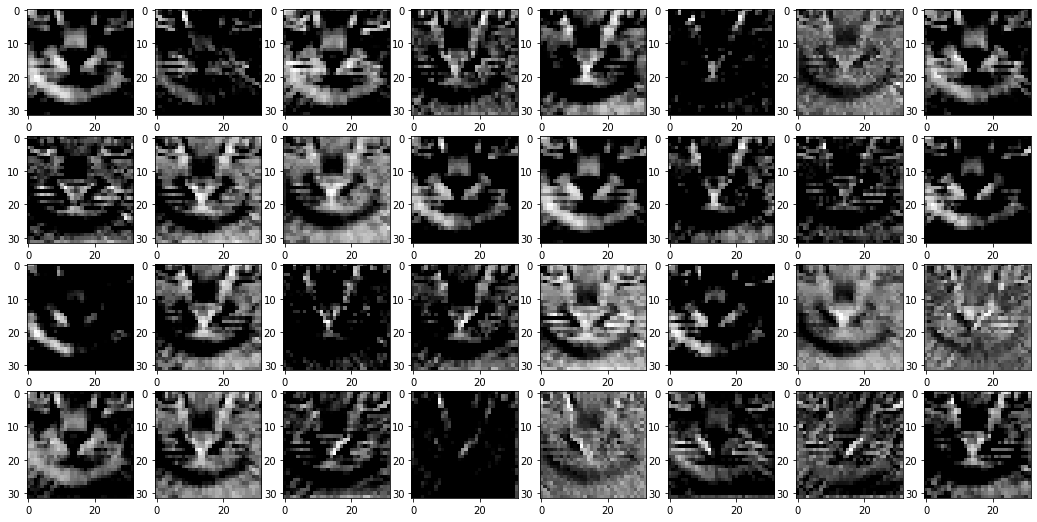

In [ ]:
conv1_pooling = MyCNN.FeatureExtractionLayer[0:3]
conv1_out1 = conv1_pooling(batchX.to(device))
imgArray=conv1_out1[0].data.cpu().numpy()
fig=plt.figure(figsize=(18, 9))
for i in range(32):
    fig.add_subplot(4, 8, i+1) 
    plt.imshow(imgArray[i], cmap='gray')
plt.show()

# Results after convolution1,Relu, MaxPooling, Conv2

In [ ]:
conv2 = MyCNN.FeatureExtractionLayer[0:4]
conv2_out = conv2(batchX.to(device))
print(conv2_out.shape)

torch.Size([1, 8, 32, 32])


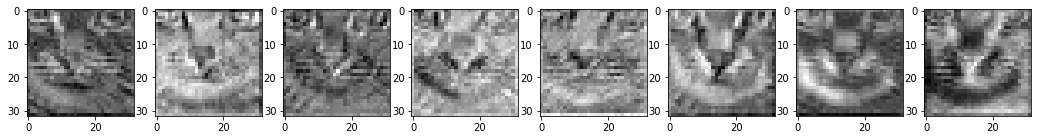

In [ ]:
# Visualize feature maps from conv layer 2
imgArray=conv2_out[0].data.cpu().numpy()
fig=plt.figure(figsize=(18,6))
for i in range(8):
    fig.add_subplot(1, 8, i+1) 
    plt.imshow(imgArray[i], cmap='gray')
plt.show()

# After Relu and MaxPooling

In [ ]:
conv15 = MyCNN.FeatureExtractionLayer[0:6]
conv15_out = conv15(batchX.to(device))
print(conv15_out.shape)

torch.Size([1, 8, 16, 16])


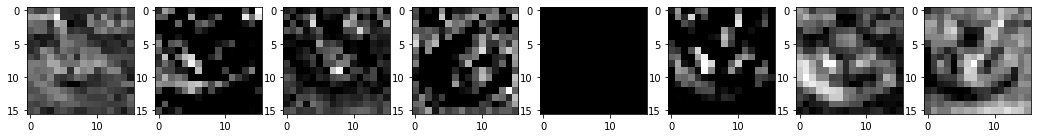

In [ ]:
# Visualize feature maps from conv layer 2
imgArray=conv15_out[0].data.cpu().numpy()
fig=plt.figure(figsize=(18, 9))
for i in range(8):
    fig.add_subplot(1, 8, i+1) 
    plt.imshow(imgArray[i], cmap='gray')
plt.show()

# Flattern

In [ ]:
temp = torch.flatten(conv15_out, 1)
temp.shape

torch.Size([1, 2048])

In [ ]:
8 * 16 * 16

2048

# Send to MLP classifier

In [ ]:
MyCNN.MLPClassifier(temp)

tensor([[-0.0671, -0.0644]], device='cuda:0', grad_fn=<AddmmBackward>)

# Input img passed to entire CNN

In [ ]:
y1 = MyCNN(batchX)   
print(y1)

tensor([[-0.0252, -0.1049]], device='cuda:0', grad_fn=<AddmmBackward>)
